# Bubble wall velocity under LTE

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt
import plotter as pl
from helperFunctions import derivative, alpha_p, cs_sq, dYdtau, dvTdxi, r_func, μ, w

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Sech = lambda x: 1/np.cosh(x)
Tanh = np.tanh
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


def Plot(fun, xminmax, n=100,xfun=np.linspace, xlog=False, ylog=False):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

## Prepare

Import model

In [2]:
import SM_model as m

In [3]:
mod = m.SM(1,0.007285228,636.8644639563023)

Model inialized.
g2 = 1
λ = 0.007285228
μh = 25.236173718618723


In [4]:
mod.findTc()
mod.findTn()

Finding Tc...
Critical temperature found! Tc = 56.636213599704206
v_c/Tc = 2.805112061801922
Finding Tn...
Tunneling at T = 56.6162135997042
S3/T = 1776610.8238727949
Tunneling at T = 56.5962135997042
S3/T = 451853.48778122134
Tunneling at T = 56.576213599704204
S3/T = 203892.62051154784
Tunneling at T = 56.5562135997042
S3/T = 116379.0262333563
Tunneling at T = 56.536213599704205
S3/T = 75553.789088199
Tunneling at T = 56.5162135997042
S3/T = 53207.22592941783
Tunneling at T = 56.496213599704205
S3/T = 39631.40597681824
Tunneling at T = 56.4762135997042
S3/T = 30754.56577217449
Tunneling at T = 56.456213599704206
S3/T = 24623.81272947193
Tunneling at T = 56.4362135997042
S3/T = 20206.517098491207
Tunneling at T = 56.4162135997042
S3/T = 16914.527910790166
Tunneling at T = 56.396213599704204
S3/T = 14392.707458428697
Tunneling at T = 56.3762135997042
S3/T = 12416.14990604183
Tunneling at T = 56.356213599704205
S3/T = 10836.688220748267
Tunneling at T = 56.3362135997042
S3/T = 9553.5147

In [5]:
mod.findα()
mod.findβH()

α = 0.020951317966704273
β/H = 5236.316760834551


In [6]:
Vtot=mod.Vtot
hv = np.array([0.0])
lv = np.array([mod.Tnvev])
Tnuc = mod.Tn

In [7]:
from helperFunctions import a

## Solving the boundary conditions for deflagration

In [8]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

def find_Tsh(Tm, vw, type='def'):
    if type=='def':
        guess_sol = optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.1,Tnuc])
    elif type=='hyb':
        guess_sol = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.1,Tnuc])

    # Integrate outside the wall to the shock-wave front
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        try:
            xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max)
        except:
            xsh = xi_max
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

In [9]:
Tnuc

53.319382365441314

In [22]:
find_Tsh(53, 0.1)

array(53.05900391)

In [9]:
Tmax = Tnuc
Tmin = 50
vw = 0.1
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal, vw)
    if Tsh < Tnuc:
        Tmin = Tcal
    else:
        Tmax = Tcal
Tm = Tcal
vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)
hv_new = mod.findMinimum(hv, Tp)
lv_new = mod.findMinimum(lv, Tm)

In [12]:
Tm

53.26642606458701

In [13]:
Tp

53.34217346354387

In [14]:
find_Tsh(Tnuc, vw)

array(53.2562584)

In [7]:
a(Vtot, Tnuc, hv)

89.86973276570005

In [72]:
np.pi**2 * 106.75/30

35.11934232720964

In [8]:
a(Vtot, Tnuc, lv)

88.07649858738239

In [16]:
5.91/7.7

0.7675324675324675

In [10]:
alpha_p(Vtot, Tnuc, Tnuc, hv, lv)

0.008187366593479036

In [11]:
mod.α

0.020951317966704273

In [12]:
# Estimate vJ
(Sqrt(mod.α*(2+3*mod.α)) + 1)/(Sqrt(3)*(1+mod.α))

0.6830662244523567

In [69]:
def vJ(a):
    return (Sqrt(a*(2+3*a)) + 1)/(Sqrt(3)*(1+a))

## Solve hybrid boundary conditions

In [35]:
vw = 0.6

In [50]:
Tm=53
cs_sq(Vtot, Tm, lv)**0.5

0.5745822856458147

In [19]:
guess_sol = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.5,Tnuc])

In [20]:
guess_sol

array([ 0.50566074, 55.89279946])

In [52]:
find_Tsh(50, 0.6, 'hyb')

array(52.15453178)

In [53]:
Tmax = Tnuc
Tmin = 50
vw = 0.6
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal, vw, 'hyb')
    if Tsh < Tnuc:
        Tmin = Tcal
    else:
        Tmax = Tcal
Tm = Tcal
lv_new = mod.findMinimum(lv, Tm)
vp, Tp = optimize.fsolve(lambda x:match(x[0],cs_sq(Vtot, Tm, lv_new)**0.5,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)
hv_new = mod.findMinimum(hv, Tp)

In [36]:
vw=0.6
Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc-1)
Tm

51.25056362691644

In [42]:
vm = cs_sq(Vtot, Tm, lv)**0.5
vp, Tp = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.5,Tnuc])

In [41]:
[vp, Tp]

[0.49755496453362646, 54.36539269692399]

In [43]:
vm

0.5743224778531787

In [45]:
lv_new = mod.findMinimum(lv, Tm)

In [46]:
lv_new

array([202.29370272])

In [47]:
lv

array([190.80359172])

## Solve detonation boundary conditions

In [67]:
vw=0.7
gsol=optimize.fsolve(lambda x:match(vw, x[0], Tnuc, x[1], hv, lv),[0.7,Tnuc+0.5])

In [68]:
gsol

array([ 0.68196933, 54.5579471 ])

In [71]:
vJ(alpha_p(Vtot, Tnuc, gsol[1], hv, lv))

0.6434963594670974

## Solve the temperature profile and the moments

In [48]:
h0 = lv_new

def h_profile(z, Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz
c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
s1=c1
c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
s2=c2

In [49]:
def T33(T,z, Lh):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    field_value = [h_profile(z, Lh)]
    return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

In [50]:
Lh = 0.1
npoints = 100
z_range = np.linspace(-8*Lh, 5*Lh, npoints)
T_sol = np.zeros((npoints,))
for i in range(npoints):
    T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
    if T33min.fun > 0:
        T_sol[i]=T33min.x[0]
    else:
        try:
            s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
        except:
            s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
        T_sol[i] = s

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_41009/2484720252.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


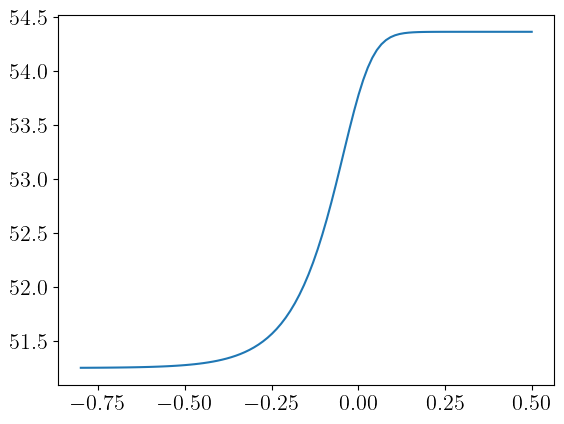

In [51]:
plt.plot(z_range, T_sol)

In [54]:
def moments(Lh):
    npoints = 100
    z_range = np.linspace(-8*Lh, 5*Lh, npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
            T_sol[i] = s

    hvalues = h_profile(z_range, Lh)
    hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
    d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
    Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
    Ph = np.trapz(- Eh * hprime(z_range), z_range)
    Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
    return np.array([Ph, Gh])/1e6

In [55]:
moments(0.1)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_41009/3946513898.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


array([-1.09734706, -0.18089205])

In [18]:
optimize.newton(lambda L: moments(L)[-1], 0.1)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_76496/3946513898.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


0.11884969591702182

In [19]:
moments(0.11884969591702182)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_76496/3946513898.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


array([-1.12486595e+00,  2.60257517e-10])

In [18]:
vwlist = np.linspace(0.1,0.65,10)
Plist = np.zeros((10,))

In [31]:
def Ptot(vw):
    print("vw = " + str(vw))
    # Test solution type. Start from deflagration to test.
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc-1)
    lv_new = mod.findMinimum(lv, Tm)
    if cs_sq(Vtot, Tm, lv_new)**0.5 > vw:
        print("Deflagration.")
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = vw
    else:
        print("Hybrid.")
        Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc-1)
        lv_new = mod.findMinimum(lv, Tm)
        vm = cs_sq(Vtot, Tm,lv_new)**0.5
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vm,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)


    hv_new = mod.findMinimum(hv, Tp)
    h0 = lv_new

    def h_profile(z, Lh):
        z = np.asanyarray(z)
        hz = 0.5*h0*(1-np.tanh(z/Lh))
        return hz
    c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
    s1=c1
    c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
    s2=c2

    def T33(T,z, Lh):
        derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
        field_value = [h_profile(z, Lh)]
        return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

    print('T33 prepared.')
    
    def moments(Lh):
        npoints = 100
        z_range = np.linspace(-8*Lh, 5*Lh, npoints)
        T_sol = np.zeros((npoints,))
        for i in range(npoints):
            T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
            if T33min.fun > 0:
                T_sol[i]=T33min.x[0]
            else:
                try:
                    s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
                except:
                    s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
                T_sol[i] = s

        hvalues = h_profile(z_range, Lh)
        hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
        d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
        Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
        Ph = np.trapz(- Eh * hprime(z_range), z_range)
        Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
        return np.array([Ph, Gh])/1e6
    print('Solving moments.')
    Lsol = optimize.newton(lambda L: moments(L)[-1], 0.1)
    print('Moment solved, Lh = ' + str(Lsol))
    P = moments(Lsol)[0]
    return P

In [34]:
Ptot(0.6)

vw = 0.6
Hybrid.
T33 prepared.
Solving moments.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_41009/1820964711.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Moment solved, Lh = 0.12278353862646181


-1.0825945011720606

In [56]:
Ptot(0.53)

vw = 0.53
Tm solved.
T33 prepared.
Solving moments.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_78088/3484273235.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Moment solved, Lh = 0.11891537720484018


-0.8755259431495153

In [19]:
for i in range(len(vwlist)):
    vw = vwlist[i]
    Plist[i] = Ptot(vw)
    print(Plist[i])

vw = 0.1
Deflagration.
T33 prepared.
Solving moments.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_41009/4091278593.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Moment solved, Lh = 0.11884969858787904
-1.1248658899397348
vw = 0.16111111111111112
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11887376880681116
-1.1166989537239655
vw = 0.22222222222222224
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11889233637731693
-1.1052795120607066
vw = 0.2833333333333333
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11889722472164188
-1.089748278698548
vw = 0.34444444444444444
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11888092787573662
-1.0677365703145603
vw = 0.40555555555555556
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.1188391836495458
-1.0333289721222612
vw = 0.4666666666666667
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.118827621316564
-0.9693213580345721
vw = 0.5277777777777778
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11892650843365174
-0.8752842459879312
vw = 0.5888888888888889
Hybrid.
T33 p

In [25]:
vwlist[-1]=0.62
Plist[-1]=-0.046851694176377405

Text(0, 0.5, '$P_{\\rm tot}$')

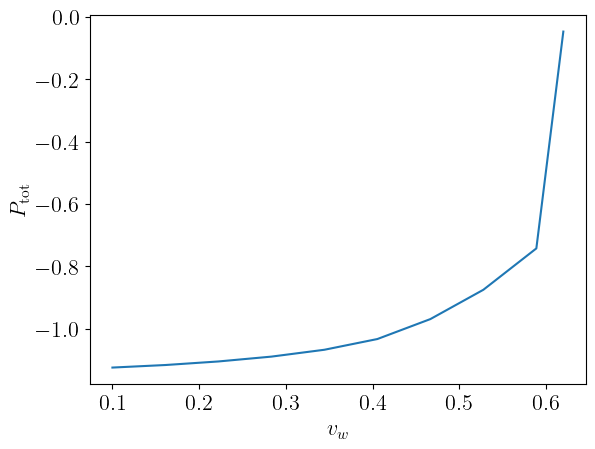

In [26]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')
plt.rc('font',size=16)
plt.plot(vwlist,Plist)
plt.xlabel(r'$v_w$')
plt.ylabel(r'$P_{\rm tot}$')

## Solve entropy vanishing instead of P vanishing

In [36]:
def entropy(V,T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)

    def VT(T):
        return V(v, T)
    
    return -derivative(VT, T, order=1)

In [27]:
def sdiff(vw):
    print("vw = " + str(vw))
    # Test solution type. Start from deflagration to test.
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc-1)
    lv_new = mod.findMinimum(lv, Tm)
    if cs_sq(Vtot, Tm, lv_new)**0.5 > vw:
        print("Deflagration.")
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = vw
    else:
        print("Hybrid.")
        Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc-1)
        lv_new = mod.findMinimum(lv, Tm)
        vp, Tp = optimize.fsolve(lambda x:match(x[0],cs_sq(Vtot, Tm,lv_new)**0.5,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = cs_sq(Vtot, Tm,lv_new)**0.5

    lv_new = mod.findMinimum(lv, Tm)

    diff = - Tp/Sqrt(1-vp**2) + Tm/Sqrt(1-vm**2)
    # diff = (- entropy(Vtot, Tp, hv) * vp/Sqrt(1-vp**2) + entropy(Vtot, Tm, lv_new) * vw/Sqrt(1-vw**2))/1e6
    return diff

In [28]:
sdiff(0.5)

vw = 0.5
Deflagration.


-0.05519401364139043

In [29]:
sdifflist = np.zeros((10,))

In [30]:
for i in range(len(vwlist)):
    sdifflist[i] = sdiff(vwlist[i])
    print(sdifflist[i])

vw = 0.1
Deflagration.
-0.06271060993342559
vw = 0.16111111111111112
Deflagration.
-0.06265389559523982
vw = 0.22222222222222224
Deflagration.
-0.06261241431823805
vw = 0.2833333333333333
Deflagration.
-0.06253275074143261
vw = 0.34444444444444444
Deflagration.
-0.062253143753416396
vw = 0.40555555555555556
Deflagration.
-0.061342892610909416
vw = 0.4666666666666667
Deflagration.
-0.05850707653770826
vw = 0.5277777777777778
Deflagration.
-0.05338021780946889
vw = 0.5888888888888889
Hybrid.
0.743202815776705
vw = 0.62
Hybrid.
2.6251197922275296


Text(0, 0.5, '$\\Delta (s \\gamma v)$')

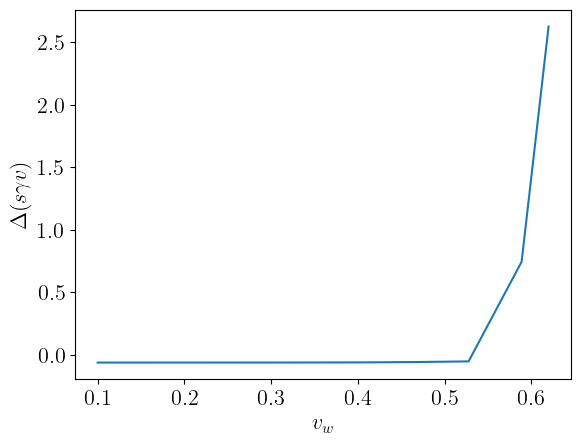

In [33]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')
plt.plot(vwlist, sdifflist)
plt.xlabel(r'$v_w$')
plt.ylabel(r'$\Delta (s \gamma v)$')